In [1]:
# Librairies génériques
import numpy as np
import sys
import io
import os
import time


In [2]:
print(os.environ['SPARK_HOME'])
print(os.environ['JAVA_HOME'])
print(os.environ['PATH'])

C:\Users\loic\spark\spark-3.2.0-bin-hadoop3.2
C:\Program Files\Java\jre1.8.0_311
C:\Users\loic\anaconda3;C:\Users\loic\anaconda3\Library\mingw-w64\bin;C:\Users\loic\anaconda3\Library\usr\bin;C:\Users\loic\anaconda3\Library\bin;C:\Users\loic\anaconda3\Scripts;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Intel\iCLS Client\;C:\Program Files\Intel\iCLS Client\;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Microsoft VS Code\bin;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files\Intel\Intel(R) Management Engine Components\IPT;C:\Program 

In [4]:
import findspark
findspark.init()
findspark.find()

import pyspark
findspark.find()


'C:\\Users\\loic\\spark\\spark-3.2.0-bin-hadoop3.2'

In [5]:
# Librairies pyspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType


In [6]:
# Librairies pour le traitement d'images
from PIL import Image
import cv2


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Changer la taille de police par défaut
plt.rcParams.update({'font.size': 15})

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 400)
pd.set_option('display.column_space', 200)


In [8]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50


<IPython.core.display.Javascript object>

# Table des matières

In [9]:
# nom du répertoire (data_select pour les tests)
# folder = "fruit-360"
folder = "images/"
ci = "chemin_image"
nombre_variable = 10

# C:\\Users\\loic\\Documents\\FORMATION\\Data Scientist\\Projet_8\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana
# C:\\Users\\loic\\Documents\\FORMATION\\Data Scientist\\Projet_8\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado

# TEST
sub_folders = os.listdir("C:\\Users\\loic\\Documents\\FORMATION\\Data Scientist\\Projet_8\\images")
print(sub_folders)   # Liste tous les noms de fichiers si folder terminal, sinon tous les sous-répertoires


['Avocado', 'Banana']


## Définition des fonctions nécessaires

In [10]:
# 2eme colonne du dataframe:  catégorie du fruit

def give_categ(chemin):
    return chemin.split('/')[-2]


In [11]:
# 3eme colonne du dataframe:  matrice de chaque image mise à plat

def image_to_list(chemin):
    try:
        image = Image.open(chemin)
        image = np.asarray(image)
        image = image.flatten().tolist()
        return image
    except:
        return [0]


In [12]:
# 4eme colonne du dataframe:  descripteurs de chaque image

def give_descripteurs(chemin):
    
    image = np.asarray(Image.open(chemin))
    orb = cv2.ORB_create(nfeatures=nombre_variable)
    keypoints, desc = orb.detectAndCompute(image, None)
    
    if desc is None:
        desc = 0
    else:
        desc = desc.flatten().tolist()
    return desc


# Création du DataFrame et distribution des calculs

In [ ]:
spark = SparkSession.builder.appName('name').getOrCreate()
sc = SparkContext.getOrCreate()
sc.setLogLevel("Warn")


In [14]:
# Création d'un DataFrame PySpark avec une 1ère colonne
#  représentant le chemin complet des images.

lst_path = []
sub_folders = os.listdir(folder)
print(sub_folders)

for f in sub_folders:
    lst_categ = os.listdir(folder+f)
    for file in lst_categ:
        lst_path.append(folder+f+"/"+file)
            
print("Nombre d'images chargées :", len(lst_path))
    
rdd = sc.parallelize(lst_path)
row_rdd = rdd.map(lambda x: Row(x))
df = spark.createDataFrame(row_rdd, [ci])


['Avocado', 'Banana']
Nombre d'images chargées : 917


# Exécution des calculs et enregistrement des résultats

In [15]:
# Remplissage de la colonne catégorie
udf_categ = udf(give_categ, StringType())
df = df.withColumn("categ", udf_categ(ci))

# Remplissage de la colonne image. 
# Chaque image a été transformé en array numpy puis vecteur unitaire
udf_image = udf(image_to_list, ArrayType(IntegerType()))
df = df.withColumn("image", udf_image(ci))
df = df.filter(df.image.isNotNull())

# Remplissage de la colonne descripteur avec les descripteurs de 
# chaque image transformés en vecteur unitaire
udf_desc = udf(give_descripteurs, ArrayType(IntegerType()))
df = df.withColumn("descripteurs", udf_desc(ci))
df = df.filter(df.descripteurs.isNotNull())


In [16]:
# les transformations sont lancées par  "df.show"
start_time = time.time()
df.show()

print("Temps execution %sec ---" % (time.time() -  start_time))


+--------------------+-------+--------------------+--------------------+
|        chemin_image|  categ|               image|        descripteurs|
+--------------------+-------+--------------------+--------------------+
|images/Avocado/0_...|Avocado|[255, 255, 255, 2...|[197, 253, 189, 2...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[212, 236, 159, 2...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[228, 36, 157, 24...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[220, 140, 157, 1...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[244, 36, 189, 25...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[188, 164, 156, 1...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[68, 229, 157, 11...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[124, 165, 29, 11...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[228, 165, 157, 1...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|[244, 36, 189, 11...|
|images/Avocado/10...|Avocado|[255, 255, 255, 2...|

In [39]:
df.toPandas().to_csv('result_local.csv')


# Chargement des données

In [28]:
# Dans les répertoires suivants, les images ont la même taille et n'ont pas besoin d'être modifiées.

# C'est avec ORB que la liste des points est défini pour chaque image (60)

# C:\Users\loic\Documents\FORMATION\Data Scientist\Projet_8\data\fruits-360_dataset\fruits-360\Training\Banana
# C:\Users\loic\Documents\FORMATION\Data Scientist\Projet_8\data\fruits-360_dataset\fruits-360\Training\Avocado

# Créer un dataframe avec comme colonnes:
# - nom de l'image
# - catégorie (abricot/avocat)
# - colonnes de descripteurs (60)

# Faire une réduction ACP pour passer de 60 variables à 3,4 (F1,F2,F3,F4)



### Banane

In [34]:
list_images = os.listdir('.\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana')   # 1ère liste

list_ba = ['ba'] * len(list_images)     # crée une 2nd liste de même taille contenant 'ba'

df_ba = pd.DataFrame(list(zip(list_images,list_ba)), columns = ['image','categ'])
print("Nombre de bananes:", len(df_ba))
# print(df_ba)


Nombre de bananes: 490


### Avocat

In [35]:
list_images = os.listdir('.\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado')   # 1ère liste

list_av = ['av'] * len(list_images)     # crée une 2nd liste de même taille contenant 'av'

df_av = pd.DataFrame(list(zip(list_images,list_av)), columns = ['image','categ'])
print("Nombre d'avocats:", len(df_av))
# print(df_av)


Nombre d'avocats: 427


In [36]:
# Concaténation des dataframes abricot et avocat :

df_images = pd.concat([df_ba, df_av], axis=0)
df_images.reset_index(drop = True, inplace = True)
nb_images = len(df_images)
print("Nombre d'images:", nb_images)

# Contrôle :
df_images['categ'].value_counts()


Nombre d'images: 917


ba    490
av    427
Name: categ, dtype: int64

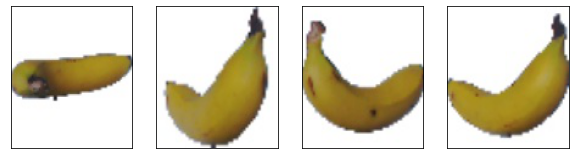

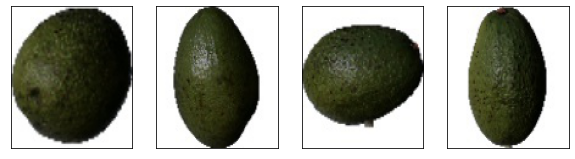

In [37]:
# --- Affichage aléatoires de (nb_categ_fruits * 4) images ---

# from PIL import Image

categories = ["ba", "av"]

path_ba = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana\\"
path_av = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado\\"
path_img = ""

f = list(np.arange(0,nb_images))
c = 4
r = random.sample(f, c)   # Dans 'f', on prend 'c' images

nrows = 1
ncols = 4

for categ in categories:
    X = df_images[df_images['categ'] == categ]
    f = list(X.index)
    r = random.sample(f, c)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*10, ncols*3))

    for i in range(c):
        categ = str(df_images["categ"][r[i]])
        if categ == 'ba':
            path_img = path_ba
        else:
            path_img = path_av
        img_name = path_img+df_images["image"][r[i]]
        img = Image.open(img_name)
        plt.subplot(4, 4, i+1)
        plt.imshow(img, aspect='auto')
        plt.xticks([])
        plt.yticks([])
    #fig.savefig("subplot2_"+categ)
    plt.show()


### Détection des KeyPoints (KP) sur UNE image

In [8]:
import numpy as np
import cv2
# cv2.__version__   # '4.5.4-dev'

# Tests sur plusieurs images :

path_img = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana\\"
file = os.path.join(path_img, "0_100.jpg")   # (6, 32)
file = os.path.join(path_img, "1_100.jpg")   # (3, 32)
file = os.path.join(path_img, "2_100.jpg")   # (6, 32)

# La détection des KeyPoints ne semble pas marcher avec les abricots, étrange !
path_img = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado\\"
file = os.path.join(path_img, "0_100.jpg")   # (11, 32)
file = os.path.join(path_img, "1_100.jpg")   # (10, 32)
file = os.path.join(path_img, "2_100.jpg")   # (9, 32)
file = os.path.join(path_img, "3_100.jpg")   # (10, 32)

# file = "C:\\Users\\loic\\Documents\\FORMATION\\Data Scientist\\Projet_8\\Schema_environement.PNG"   # (500, 32)
# file = "C:\\Users\\loic\\Documents\\FORMATION\\Data Scientist\\Projet_8\\Step4_add_storage.PNG"     # (500, 32)

img = cv2.imread(file)
  
# Convert the image to RGB
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # ne change pas le nombre de descripteurs/image
 
# Initialize the ORB detector algorithm. cv2.ORB() existe aussi.
orb = cv2.ORB_create()

  
# Now detect the keypoints and compute the descriptors for the image
Keypoints, Descriptors = orb.detectAndCompute(img, None)
# type(Descriptors)
Descriptors.shape   # (n, 32), le nombre de descripteurs 'n' dépend de l'image traitée.
# Descriptors       # Prendre en compte le cas ou Descriptors=null (image sans KP)
# Keypoints (KP)

# Les abricots ont très peu de KP. J'ai du les remplacer par les avocats


(10, 32)

### Détection des KeyPoints sur TOUTES les images

In [38]:
import numpy as np
import cv2

path_img_ba = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana"
path_img_av = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado"


for i in df_images.index:
    nom_image = df_images.iloc[i].image
    categ_image = df_images.iloc[i].categ
    print(categ_image)
    if categ_image == 'ba':
        file_image = os.path.join(path_img_ba, nom_image)
    else:
        file_image = os.path.join(path_img_av, nom_image)
        
    img = cv2.imread(file_image)
    orb = cv2.ORB_create()
    Keypoints, Descriptors = orb.detectAndCompute(img, None)
    if not(Keypoints):
        print("Image", file_image,"sans KP")    # image sans descripteur
        continue
    print(Descriptors.shape)


ba
(6, 32)
ba
(11, 32)
ba
(10, 32)
ba
(5, 32)
ba
(10, 32)
ba
(5, 32)
ba
(9, 32)
ba
(6, 32)
ba
(4, 32)
ba
(6, 32)
ba
(6, 32)
ba
(4, 32)
ba
(6, 32)
ba
(6, 32)
ba
(8, 32)
ba
(9, 32)
ba
(10, 32)
ba
(7, 32)
ba
(6, 32)
ba
(8, 32)
ba
(9, 32)
ba
(5, 32)
ba
(6, 32)
ba
(8, 32)
ba
(7, 32)
ba
(7, 32)
ba
(10, 32)
ba
(8, 32)
ba
(7, 32)
ba
(6, 32)
ba
(5, 32)
ba
(12, 32)
ba
(15, 32)
ba
(9, 32)
ba
(10, 32)
ba
(13, 32)
ba
(16, 32)
ba
(18, 32)
ba
(15, 32)
ba
(14, 32)
ba
(12, 32)
ba
(11, 32)
ba
(12, 32)
ba
(16, 32)
ba
(16, 32)
ba
(6, 32)
ba
(9, 32)
ba
(8, 32)
ba
(10, 32)
ba
(7, 32)
ba
(6, 32)
ba
(10, 32)
ba
(6, 32)
ba
(8, 32)
ba
(15, 32)
ba
(10, 32)
ba
(15, 32)
ba
(18, 32)
ba
(18, 32)
ba
(16, 32)
ba
(23, 32)
ba
(22, 32)
ba
(28, 32)
ba
(22, 32)
ba
(21, 32)
ba
(17, 32)
ba
(20, 32)
ba
(16, 32)
ba
(16, 32)
ba
(14, 32)
ba
(12, 32)
ba
(12, 32)
ba
(6, 32)
ba
(13, 32)
ba
(11, 32)
ba
(12, 32)
ba
(14, 32)
ba
(3, 32)
ba
(14, 32)
ba
(15, 32)
ba
(14, 32)
ba
(16, 32)
ba
(14, 32)
ba
(15, 32)
ba
(11, 32)
ba
(12, 32)
ba
(

(4, 32)
av
(4, 32)
av
(3, 32)
av
(5, 32)
av
(4, 32)
av
(4, 32)
av
(12, 32)
av
(1, 32)
av
(4, 32)
av
(3, 32)
av
(3, 32)
av
(2, 32)
av
(2, 32)
av
(1, 32)
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_137_100.jpg sans KP
av
(2, 32)
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_139_100.jpg sans KP
av
(10, 32)
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_140_100.jpg sans KP
av
(1, 32)
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_142_100.jpg sans KP
av
(1, 32)
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_144_100.jpg sans KP
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_145_100.jpg sans KP
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_146_100.jpg sans KP
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_147_100.jpg sans KP
av
Image .\data\fruits-360_dataset\fruits-360\Training\Avocado\r_148_100.jpg sans KP
av
Image .\data\fruits-360_dataset\fru

### Fonction de conversion d'un Dictionnaire de descripteurs -> Array

In [39]:
def dict2numpy(dict):
    
    nkeys = len(dict)                               # nkeys :  nombre d'images (max= 1050)
    array = np.zeros((nkeys * 200, 32))             # allocation d'un array de "nkeys*200" lignes pour 32 colonnes
                                                        # Hypothèse: une image à 200 Key Points (= 200 descripteurs)
    pivot = 0                                       # nombre de descripteurs cumulé aprés chaque image
    for key in dict.keys():
        value = dict[key]                           # les descripteurs d'UNE image
        #print("Image :", key," -> Nb descripteurs =", value.shape[0])
        nelements = value.shape[0]                  # Nb descripteurs pour UNE image
        while pivot + nelements > array.shape[0]:   # Tant que l'array est trop petit
            padding = np.zeros_like(array)
            array = np.vstack((array, padding))     # concaténe verticalement 'padding' à 'array'
        array[pivot:pivot + nelements] = value
        pivot += nelements
    array = np.resize(array, (pivot, 32))
    return array


### Création d'un dictionnaire de descripteurs sur un échantillon d'images

In [40]:
dict_des  = {}   # dictionnaire (1 image contient X desccripteurs)
img_no_kp = []

path_img_ba = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana"
path_img_av = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado"

c = 2                               # Nombre d'images à traiter
f = list(np.arange(0,nb_images))
r = random.sample(f, c)             # Dans 'f', on prend 'c' images


for i in range(c):
    nom_image = df_images.iloc[i].image
    categ_image = df_images.iloc[i].categ
    print(categ_image)
    if categ_image == 'ba':
        file_image = os.path.join(path_img_ba, nom_image)
    else:
        file_image = os.path.join(path_img_av, nom_image)
        
    img = cv2.imread(file_image)
    orb = cv2.ORB_create()
    Keypoints, Descriptors = orb.detectAndCompute(img, None)
    
    if not(Keypoints):              # image sans descripteur
        continue
    
    print("Image :", i," -> Nbr descripteurs =", Descriptors.shape[0])
    dict_des[str(i)] = Descriptors

Descriptors.shape


ba
Image : 0  -> Nbr descripteurs = 6
ba
Image : 1  -> Nbr descripteurs = 11


(11, 32)

In [41]:
# Conversion du dictionnaire de descripteurs des 70 images -> array.

images_array = dict2numpy(dict_des)
print(images_array.shape)


(17, 32)


### Création d'un dictionnaire de descripteurs de toutes les images

In [42]:
dict_des  = {}   # dictionnaire (1 image contient X desccripteurs)
img_no_kp = []

path_img_ba = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Banana"
path_img_av = ".\\data\\fruits-360_dataset\\fruits-360\\Training\\Avocado"

for i in df_images.index:
    
    nom_image = df_images.iloc[i].image
    categ_image = df_images.iloc[i].categ
    print(categ_image)
    if categ_image == 'ba':
        file_image = os.path.join(path_img_ba, nom_image)
    else:
        file_image = os.path.join(path_img_av, nom_image)
        
    img = cv2.imread(file_image)
    orb = cv2.ORB_create()
    Keypoints, Descriptors = orb.detectAndCompute(img, None)
    
    if not(Keypoints):              # image sans descripteur
        print("image",i,"sans Key Point")
        img_no_kp.append(i)
        continue
    else:
        print("Image :", i," -> Nbr descripteurs =", Descriptors.shape[0])
        dict_des[str(i)] = Descriptors

        
# Suppression des images sans Key Point dans le dataframe
if img_no_kp:
    #df_images.drop(img_no_kp, inplace=True)
    print("Images sans Key Point :", img_no_kp)

print("Taille du Dictionnaire :", len(dict_des))


ba
Image : 0  -> Nbr descripteurs = 6
ba
Image : 1  -> Nbr descripteurs = 11
ba
Image : 2  -> Nbr descripteurs = 10
ba
Image : 3  -> Nbr descripteurs = 5
ba
Image : 4  -> Nbr descripteurs = 10
ba
Image : 5  -> Nbr descripteurs = 5
ba
Image : 6  -> Nbr descripteurs = 9
ba
Image : 7  -> Nbr descripteurs = 6
ba
Image : 8  -> Nbr descripteurs = 4
ba
Image : 9  -> Nbr descripteurs = 6
ba
Image : 10  -> Nbr descripteurs = 6
ba
Image : 11  -> Nbr descripteurs = 4
ba
Image : 12  -> Nbr descripteurs = 6
ba
Image : 13  -> Nbr descripteurs = 6
ba
Image : 14  -> Nbr descripteurs = 8
ba
Image : 15  -> Nbr descripteurs = 9
ba
Image : 16  -> Nbr descripteurs = 10
ba
Image : 17  -> Nbr descripteurs = 7
ba
Image : 18  -> Nbr descripteurs = 6
ba
Image : 19  -> Nbr descripteurs = 8
ba
Image : 20  -> Nbr descripteurs = 9
ba
Image : 21  -> Nbr descripteurs = 5
ba
Image : 22  -> Nbr descripteurs = 6
ba
Image : 23  -> Nbr descripteurs = 8
ba
Image : 24  -> Nbr descripteurs = 7
ba
Image : 25  -> Nbr descripte

Image : 262  -> Nbr descripteurs = 1
ba
Image : 263  -> Nbr descripteurs = 2
ba
Image : 264  -> Nbr descripteurs = 2
ba
Image : 265  -> Nbr descripteurs = 1
ba
image 266 sans Key Point
ba
Image : 267  -> Nbr descripteurs = 15
ba
image 268 sans Key Point
ba
image 269 sans Key Point
ba
image 270 sans Key Point
ba
image 271 sans Key Point
ba
Image : 272  -> Nbr descripteurs = 1
ba
Image : 273  -> Nbr descripteurs = 1
ba
Image : 274  -> Nbr descripteurs = 1
ba
Image : 275  -> Nbr descripteurs = 1
ba
Image : 276  -> Nbr descripteurs = 2
ba
Image : 277  -> Nbr descripteurs = 1
ba
Image : 278  -> Nbr descripteurs = 3
ba
Image : 279  -> Nbr descripteurs = 3
ba
Image : 280  -> Nbr descripteurs = 4
ba
Image : 281  -> Nbr descripteurs = 10
ba
Image : 282  -> Nbr descripteurs = 7
ba
Image : 283  -> Nbr descripteurs = 7
ba
Image : 284  -> Nbr descripteurs = 9
ba
Image : 285  -> Nbr descripteurs = 9
ba
Image : 286  -> Nbr descripteurs = 10
ba
Image : 287  -> Nbr descripteurs = 9
ba
Image : 288  -> N

Image : 577  -> Nbr descripteurs = 22
av
Image : 578  -> Nbr descripteurs = 18
av
Image : 579  -> Nbr descripteurs = 24
av
Image : 580  -> Nbr descripteurs = 20
av
Image : 581  -> Nbr descripteurs = 24
av
Image : 582  -> Nbr descripteurs = 21
av
Image : 583  -> Nbr descripteurs = 19
av
Image : 584  -> Nbr descripteurs = 16
av
Image : 585  -> Nbr descripteurs = 20
av
Image : 586  -> Nbr descripteurs = 21
av
Image : 587  -> Nbr descripteurs = 16
av
Image : 588  -> Nbr descripteurs = 22
av
Image : 589  -> Nbr descripteurs = 15
av
Image : 590  -> Nbr descripteurs = 29
av
Image : 591  -> Nbr descripteurs = 24
av
Image : 592  -> Nbr descripteurs = 27
av
Image : 593  -> Nbr descripteurs = 26
av
Image : 594  -> Nbr descripteurs = 32
av
Image : 595  -> Nbr descripteurs = 35
av
Image : 596  -> Nbr descripteurs = 29
av
Image : 597  -> Nbr descripteurs = 30
av
Image : 598  -> Nbr descripteurs = 27
av
Image : 599  -> Nbr descripteurs = 38
av
Image : 600  -> Nbr descripteurs = 13
av
Image : 601  -> 

Image : 866  -> Nbr descripteurs = 14
av
Image : 867  -> Nbr descripteurs = 9
av
Image : 868  -> Nbr descripteurs = 11
av
Image : 869  -> Nbr descripteurs = 8
av
Image : 870  -> Nbr descripteurs = 20
av
Image : 871  -> Nbr descripteurs = 9
av
Image : 872  -> Nbr descripteurs = 14
av
Image : 873  -> Nbr descripteurs = 10
av
Image : 874  -> Nbr descripteurs = 11
av
Image : 875  -> Nbr descripteurs = 14
av
Image : 876  -> Nbr descripteurs = 17
av
Image : 877  -> Nbr descripteurs = 11
av
Image : 878  -> Nbr descripteurs = 7
av
Image : 879  -> Nbr descripteurs = 7
av
Image : 880  -> Nbr descripteurs = 11
av
Image : 881  -> Nbr descripteurs = 14
av
Image : 882  -> Nbr descripteurs = 12
av
Image : 883  -> Nbr descripteurs = 12
av
Image : 884  -> Nbr descripteurs = 12
av
Image : 885  -> Nbr descripteurs = 15
av
Image : 886  -> Nbr descripteurs = 14
av
Image : 887  -> Nbr descripteurs = 7
av
Image : 888  -> Nbr descripteurs = 9
av
Image : 889  -> Nbr descripteurs = 9
av
Image : 890  -> Nbr desc

In [44]:
# Conversion du dictionnaire des descripteurs de toutes les images (1050) -> array.
images_array = dict2numpy(dict_des)
print(images_array.shape)


(13432, 32)


### Réduction de dimension avec ACP

In [54]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

n_comp = 8   # Nombre de composantes principales à calculer : F1,F2,F3,F4,F5,F6

X = images_array

# Calcul des 'n_comp' premières composantes principales
pca = PCA(n_components=n_comp)
pca.fit(X) 
coord = pca.fit_transform(X)            # retourne les coordonnées factorielles

print("coord.shape :", coord.shape, "\n")
print("Variance cumulée =", pca.explained_variance_ratio_.sum())  # Variance expliquée cumulée
print(pca.components_.shape)     # (13432, 8) 



coord.shape : (13432, 8) 

Variance cumulée = 0.6096200703330463
(8, 32)
